/Users/atularavinddas/Documents/GitHub/US_Income_Maps/US_Income_Maps/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME LSAD  \
0      44      009  01219782  0500000US44009  44009  Washington   06   
1      44      007  01219781  0500000US44007  44007  Providence   06   
2      44      001  01219777  0500000US44001  44001     Bristol   06   
3      44      003  01219778  0500000US44003  44003        Kent   06   
4      44      005  01219779  0500000US44005  44005     Newport   06   

        ALAND     AWATER                                           geometry  
0   852827384  604769902  MULTIPOLYGON (((-71.61313 41.16028, -71.61053 ...  
1  1060563722   67858981  POLYGON ((-71.79924 42.00806, -71.76601 42.009...  
2    62513681   53346256  POLYGON ((-71.3539 41.7513, -71.3515 41.75264,...  
3   436563233   50711661  POLYGON ((-71.78969 41.7252, -71.72011 41.7263...  
4   265311882  546983687  MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ...  


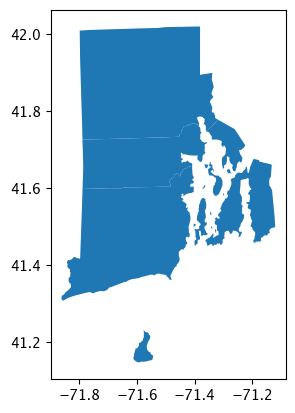

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import warnings
import pandas as pd
import os

counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip')

ri_counties = counties[counties['STATEFP'] == '44']


ri_counties.to_file('ri_county_shapefiles/ri_counties.shp')

ri_counties = gpd.read_file('ri_county_shapefiles/ri_counties.shp')


print(ri_counties.head())

ri_counties.plot()
plt.show()

# Generate Rhode Island Maps

In [3]:
ri_parameters=pd.read_csv("NEW ENGLAND's data (states) - RI.csv")
ri_parameters

,COUNTY,Population,Income (per capita),Education \n(high school or higher attendance rate),Health (life expectancy),Crime rate (per population)
0,BRISTOL,"50,568","$58,817",93.50%,80.7,0.0440
1,KENT,"171,278","$50,140",92.50%,78.2,0.1760
2,NEWPORT,"83,832","$60,198",94.80%,82.1,0.0659
3,PROVIDENCE,"660,615","$40,359",86.40%,78.2,0.6370
4,WASHINGTON,"129,982","$58,997",96.50%,80.3,0.0769


In [4]:
ri_counties['NAME']=ri_counties['NAME'].str.upper()


In [6]:
ri_counties['Population'] = ri_parameters['Population'].str.replace(',', '').astype(float)
ri_counties['Income'] = ri_parameters['Income (per capita)'].str.replace('$', '').str.replace(',', '').astype(float)
ri_counties['Education']=ri_parameters['Education \n(high school or higher attendance rate)'].str.replace('%', '').astype(float)
ri_counties['Health']=ri_parameters['Health (life expectancy)']
ri_counties['Crime Rate']=ri_parameters['Crime rate (per population)']

ri_counties['Income'] = pd.to_numeric(ri_counties['Income'], errors='coerce')
ri_counties['Education'] = pd.to_numeric(ri_counties['Education'], errors='coerce')
ri_counties['Health'] = pd.to_numeric(ri_counties['Health'], errors='coerce')
ri_counties['Crime Rate'] = pd.to_numeric(ri_counties['Crime Rate'], errors='coerce')
ri_counties['Population'] = pd.to_numeric(ri_counties['Population'], errors='coerce')



In [8]:
ri_counties = ri_counties.dissolve(by='NAME', aggfunc='first').reset_index()




ri_counties = ri_counties.to_crs(epsg=4326)

m = folium.Map(location=[44, -71], zoom_start=6)


# All your choropleth layers
folium.Choropleth(
    geo_data=ri_counties,
    name='Income',
    data=ri_counties,
    columns=['NAME', 'Income'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Income per Capita ($)',
    overlay=True,
    show=True
).add_to(m)

folium.Choropleth(
    geo_data=ri_counties,
    name='Education',
    data=ri_counties,
    columns=['NAME', 'Education'],
    key_on='feature.properties.NAME',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Education (%)',
    overlay=True,
    show=False
).add_to(m)

folium.Choropleth(
    geo_data=ri_counties,
    name='Healthcare',
    data=ri_counties,
    columns=['NAME', 'Health'],
    key_on='feature.properties.NAME',
    fill_color='Purples',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Life Expectancy',
    overlay=True,
    show=False
).add_to(m)

folium.Choropleth(
    geo_data=ri_counties,
    name='Crime Rate',
    data=ri_counties,
    columns=['NAME', 'Crime Rate'],
    key_on='feature.properties.NAME',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Crime Rate',
    overlay=True,
    show=False
).add_to(m)

folium.Choropleth(
    geo_data=ri_counties,
    name='Population',
    data=ri_counties,
    columns=['NAME', 'Population'],
    key_on='feature.properties.NAME',
    fill_color='Oranges',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Population',
    overlay=True,
    show=False
).add_to(m)

# Create a feature group with higher z-index for tooltips
tooltip_layer = folium.FeatureGroup(name='County Info', overlay=True, control=True, show=True)

# Add GeoJson to the feature group
folium.GeoJson(
    ri_counties,
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'Population', 'Income', 'Education', 'Health', 'Crime Rate'],
        aliases=['County:', 'Population:', 'Income/capita:', 'Education %:', 'Life Expectancy:', 'Crime Rate:'],
        style='background-color: white; color: black; font-size: 12px; padding: 10px;',
        sticky=False
    ),
    style_function=lambda x: {
        'fillOpacity': 0,
        'color': 'black',
        'weight': 0.5,
        'zIndex': 1000  # High z-index to stay on top
    },
    highlight_function=lambda x: {
        'weight': 2,
        'color': 'yellow'
    }
).add_to(tooltip_layer)


tooltip_layer.add_to(m)

folium.LayerControl().add_to(m)

m.save('ri_counties_map.html')